# **Load Data**

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
data = pd.concat([df_train, df_test], axis = 0)
data.reset_index(drop = True, inplace = True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# **Data Visualization - Base Model**

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

<Axes: xlabel='Sex', ylabel='count'>

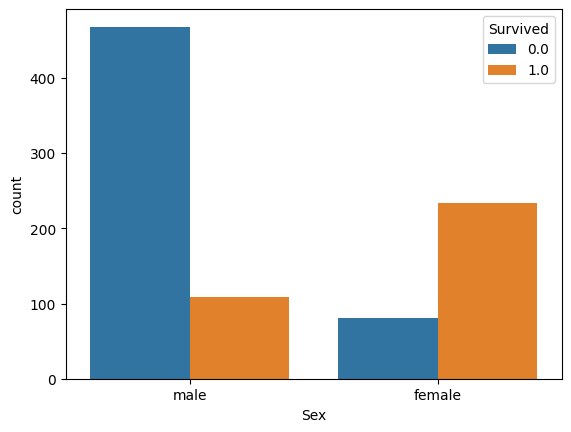

In [2]:
display(data.groupby('Sex')['Survived'].mean())
sns.countplot(data, x = 'Sex', hue = 'Survived')

* Female has a significant higher chance of surviving than Male

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

<Axes: xlabel='Pclass', ylabel='count'>

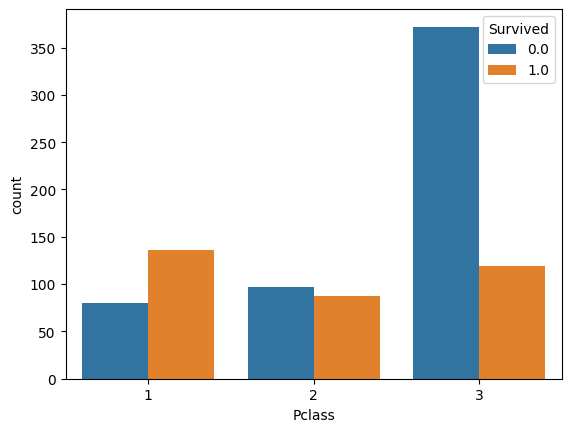

In [3]:
display(data.groupby('Pclass')['Survived'].mean())
sns.countplot(data, x = 'Pclass', hue = 'Survived')

* The first class has the highest chance of surviving, then the second class, and the last is the third class

# **Feature Engineering - Base Model**

In [4]:
data['Sex_code'] = np.where(data['Sex'] == 'male', 1, 0)

data_base_model_train= data[data['Survived'].notnull()][['Sex_code', 'Pclass']]
data_base_model_test = data[data['Survived'].notnull()]['Survived']

# **Model Training - Base Model**

In [5]:
base_model = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
base_model.fit(data_base_model_train, data_base_model_test)
print(f'Base OOB Score: {(base_model.oob_score_).round(5)}')

Base OOB Score: 0.73176


*******

# **Data Visualization - Model V1**

<Axes: xlabel='Fare', ylabel='Count'>

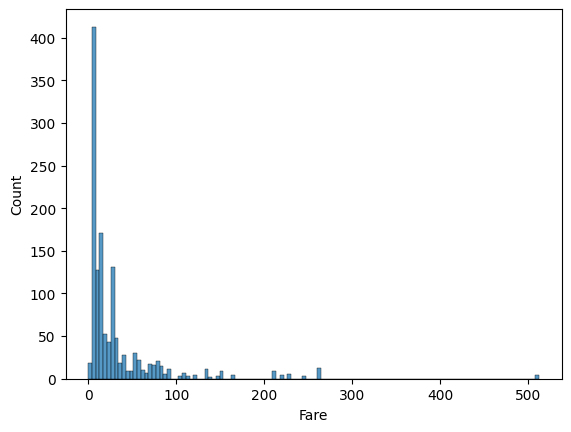

In [6]:
sns.histplot(data, x = 'Fare')

* The data distribution for "Fare" is very wide and inclined
* Do Log10 for each value can make the graph looks better
* Make the data more linear -> Easier to understand the data

<Axes: title={'center': 'Fare after doing Log'}, xlabel='Fare_LOG', ylabel='Count'>

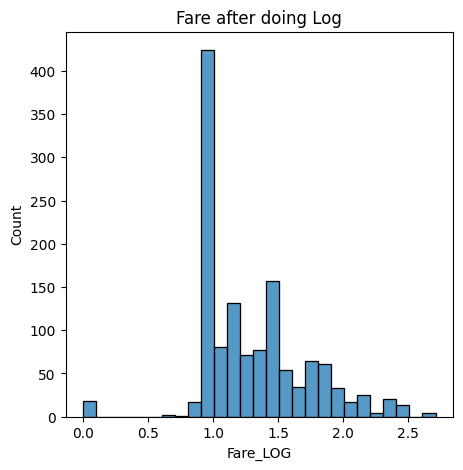

In [7]:
data['Fare_LOG'] = (data['Fare']+1).apply(lambda x: np.log10(x) if x > 0 else 0)
fig, ax = plt.subplots(figsize = (5, 5))
ax.set_title('Fare after doing Log')
sns.histplot(data, x = 'Fare_LOG', ax = ax)

<Axes: title={'center': 'Fare_LOG & PClass & Survived'}, xlabel='Fare_LOG', ylabel='Pclass'>

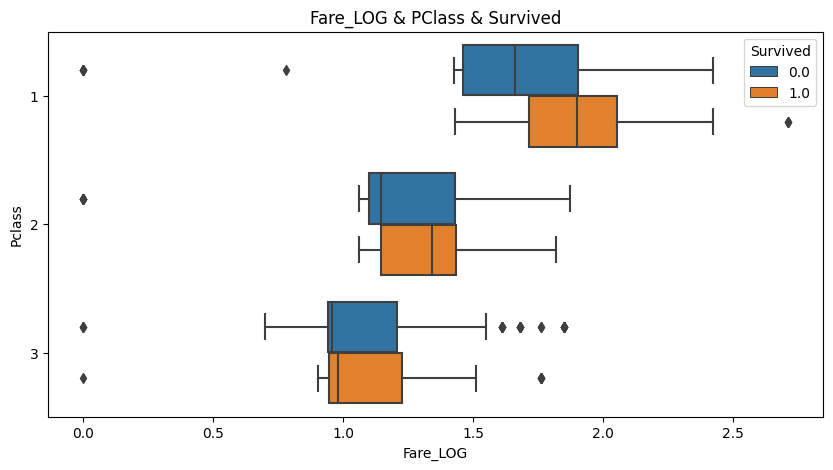

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.set_title('Fare_LOG & PClass & Survived')
sns.boxplot(data, x = 'Fare_LOG', y = 'Pclass', hue = 'Survived', ax = ax, orient = 'h')

* People who pay higher fare can live in a better class
* Higher Fare = Better Class = Higher Surviving Rate

# **Feature Engineering - Model V1**

In [9]:
#Fill Missing Value
data['Fare'].fillna(data['Fare'].median(), inplace = True)

* Now we want to cut this fare into blocks and represent it with categorical value
* Want to make sure the number of block we seperate won't lead to underfitting or overfitting

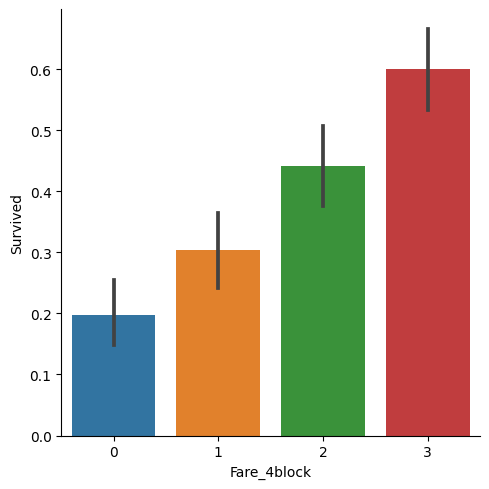

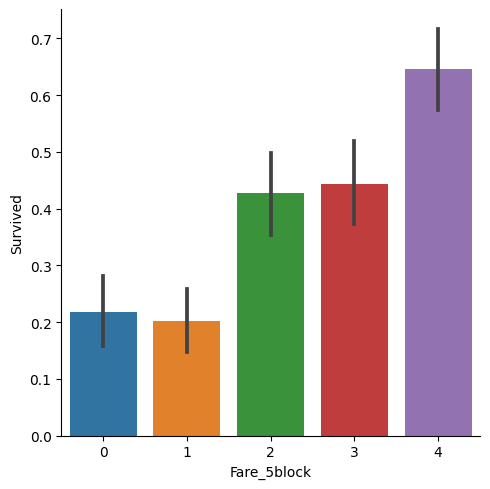

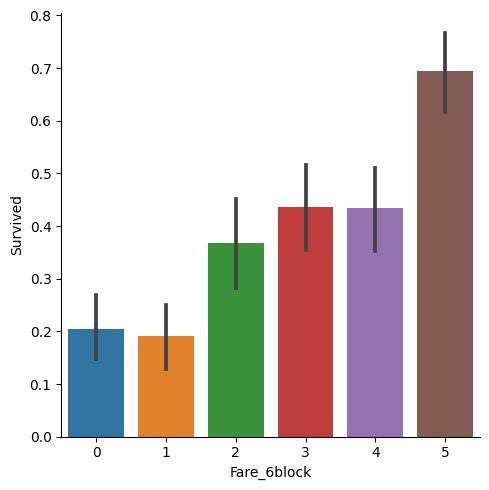

In [10]:
data['Fare_4block'] = pd.qcut(data['Fare'], 4)
data['Fare_5block'] = pd.qcut(data['Fare'], 5)
data['Fare_6block'] = pd.qcut(data['Fare'], 6)

le = LabelEncoder()
data['Fare_4block'] = le.fit_transform(data['Fare_4block'])
data['Fare_5block'] = le.fit_transform(data['Fare_5block'])
data['Fare_6block'] = le.fit_transform(data['Fare_6block'])

g1 = sns.catplot(data = data, x = 'Fare_4block', y = 'Survived', kind = 'bar')
g2 = sns.catplot(data = data, x = 'Fare_5block', y = 'Survived', kind = 'bar')
g3 = sns.catplot(data = data, x = 'Fare_6block', y = 'Survived', kind = 'bar')

# **Feature Selection - Model V1**

In [11]:
x = data[data['Survived'].notnull()].drop(['Survived'], axis = 1)
y = data[data['Survived'].notnull()]['Survived']

compare_col = ['Sex_code', 'Pclass', 'Fare_4block', 'Fare_5block', 'Fare_6block']

selector = RFECV(RandomForestClassifier(n_estimators = 250, min_samples_split = 20), cv = 10, n_jobs = -1)
selector.fit(x[compare_col], y)
print(selector.cv_results_['mean_test_score'])

[0.78672909 0.77332085 0.79354557 0.79801498 0.80254682]


* We can see Fare_6block is the best when comparing two Fare_5block and Fare_4block
* This is only one case, we have to make sure Fare_6block is better in most case

In [12]:
score_b4, score_b5, score_b6 = [], [], []
iteration = 10
for i in range(iteration):
    cf_diff = StratifiedKFold(n_splits = 10, shuffle = True, random_state = i)
    selector = RFECV(RandomForestClassifier(random_state = i, n_estimators = 250, min_samples_split = 20), cv = cf_diff, n_jobs = -1)
    selector.fit(x[compare_col], y)
    score_b4.append(selector.cv_results_['mean_test_score'][2])
    score_b5.append(selector.cv_results_['mean_test_score'][3])
    score_b6.append(selector.cv_results_['mean_test_score'][4])

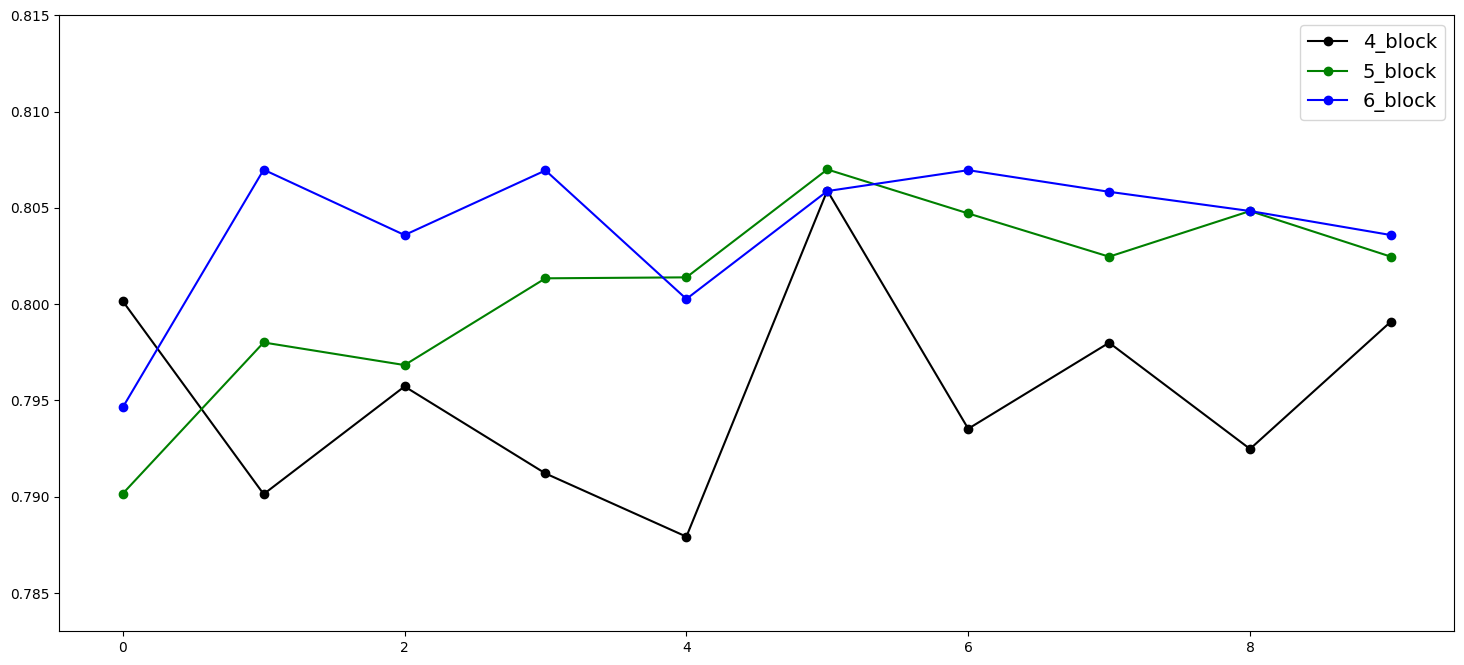

In [13]:
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)
fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(range(iteration), score_b4, '-ok', label = '4_block')
ax.plot(range(iteration), score_b5, '-og', label = '5_block')
ax.plot(range(iteration), score_b6, '-ob', label = '6_block')
ax.set_ylim(0.783, 0.815)
plt.legend(fontsize = 14, loc = 'upper right')

* We can see 6_block is slightly greater than 5_block and a lot better than 4_block

In [14]:
b4, b5, b6 = ['Sex_code', 'Pclass', 'Fare_4block'], ['Sex_code', 'Pclass', 'Fare_5block'], ['Sex_code', 'Pclass', 'Fare_6block']

b4_model = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
b4_model.fit(x[b4], y)
b5_model = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
b5_model.fit(x[b5], y)
b6_model = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
b6_model.fit(x[b6], y)

print(f"b4_model: {b4_model.oob_score_.round(5)}")
print(f"b5_model: {b5_model.oob_score_.round(5)}")
print(f"b6_model: {b6_model.oob_score_.round(5)}")

b4_model: 0.80584
b5_model: 0.81033
b6_model: 0.80135


* We can see a 5 block seperation is better when actually fitting the data
* Perhaps because of overfitting with 6 blocks

# **Model Training - Model V1**

In [16]:
model_V1_test = data[data['Survived'].isnull()][b5]
model_V1_output = b5_model.predict(model_V1_test).astype(int)
model_V1_submit = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': model_V1_output})
model_V1_submit.to_csv('submission.csv', index = False)

***

# **Data Visualization - Model V2**

In [17]:
data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

* There are 1309 value but only 929 unique values
* Some ticket number must be the same
* Maybe same ticket number = in the same family??? = in the same cabin???

In [18]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

duplicate_ticket = []
for tk in data['Ticket'].unique():
    same_ticket = data[data['Ticket'] == tk]['Ticket']
    if (same_ticket.count()>1):
        duplicate_ticket.append(data.loc[data['Ticket']==tk, ['Name', 'Ticket', 'Fare', 'Cabin', 'Family_Size', 'Survived']])

duplicate_ticket = pd.concat(duplicate_ticket)
duplicate_ticket.head(14)

,Name,Ticket,Fare,Cabin,Family_Size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
1125,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
1037,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


* For Ticket '349909', they are all in Palsson family and their family member are all dead
* For Ticket'347742', they are all in Johnson family and their family member are all survivied
* For Ticket '17463', they are not in the same family, so maybe they are friend? 
* We can see if people are in the same group, they are very likely to die or survive together, but ticket '113803' isn't the case
* There's definetely a very high relationship for people who have same ticket to live or die together

# **Feature Engineering - Model V2**

In [19]:
data['Connected_Survival'] = 0.5
for _, data_same in data.groupby('Ticket'):
    if (len(data_same) > 1):
        for ind, row in data_same.iterrows():
            smax = data_same.drop(ind)['Survived'].max()
            smin = data_same.drop(ind)['Survived'].min()
            passid = row['PassengerId']
            
            if (smax == 1):
                data.loc[data['PassengerId'] == passid, 'Connected_Survival'] = 1
            elif (smin == 0):
                data.loc[data['PassengerId'] == passid, 'Connected_Survival'] = 0

data.groupby('Connected_Survival')['Survived'].mean()

Connected_Survival
0.0    0.225352
0.5    0.297989
1.0    0.727723
Name: Survived, dtype: float64

* We can see the Connected_Survival is a very good indicator of Survived
* Connected_Survival = 1 = There's at least one person who has the same ticket survived
* Connected_Survival = 0 = There's no one who has the same ticket survived
* Connected_Survival = 0.5 = There's no one who has the same ticket / The 'Survived' is nan for people who has the same ticket

# **Model Training - Model V2**

In [20]:
col = ['Sex_code', 'Pclass', 'Fare_5block', 'Connected_Survival']
train_model_v2 = data[data['Survived'].notnull()][col]
y_train = data[data['Survived'].notnull()]['Survived']
test_model_v2 = data[data['Survived'].isnull()][col]

Model_V2 = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
Model_V2.fit(train_model_v2, y_train)
Model_V2.oob_score_

0.8237934904601572

In [21]:
output = Model_V2.predict(test_model_v2).astype(int)
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': output})
output.to_csv('final_submission.csv', index = False)

***

# **Data Visualization - Model V3**

In [22]:
data['Age'].isnull().sum() / len(data['Age'])

0.20091673032849502

* There's 20% of data missing in 'Age'
* We cannot just fill the missing value with mean or other, otherwise it's gonna be inaccurate
* First find the distribution of the missing value with respect to other feature

<Axes: xlabel='Pclass', ylabel='count'>

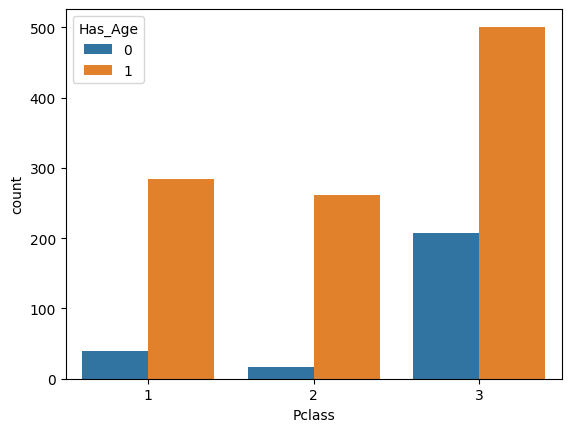

In [23]:
data['Has_Age'] = data['Age'].map(lambda x: 1 if x > 0 else 0)

sns.countplot(data, x = 'Pclass', hue = 'Has_Age')

* We can see most of the missing value is in the 3rd class
* It's probably safer to use the 1st and 2nd class to further analyze the data

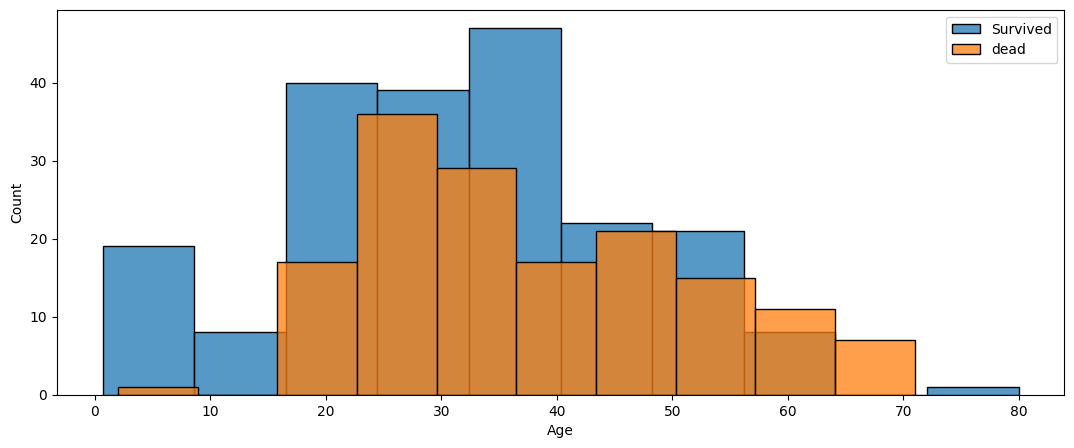

In [24]:
Mask_Survived = data.loc[((data['Has_Age'] == 1) & (data['Pclass'] != 3) & (data['Survived'] == 1)), 'Age']
Mask_Dead = data.loc[((data['Has_Age'] == 1) & (data['Pclass'] != 3) & (data['Survived'] == 0)), 'Age']

fig, ax = plt.subplots(figsize = (13, 5))
ax = sns.histplot(Mask_Survived, kde = False, bins = 10, label = 'Survived')
ax = sns.histplot(Mask_Dead, kde = False, bins = 10, label = 'dead')
ax.legend()



* We can see that for the age < 16, the survival rate is insanely high -> useful
* For age > 70, there's not enough data so just ignore it
* For 16 < age < 70, there's no obvious indicator of age has high relationship with the survival rate
* So we just gonna use age < 16 and age >= 16 as an indicator

In [25]:
data['Title'] = data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
data.groupby('Title')['Age'].median().sort_values(ascending = True)

Title
Master       4.0
Miss        22.0
Mlle        24.0
Mme         24.0
Ms          28.0
Mr          29.0
Countess    33.0
Mrs         35.5
Jonkheer    38.0
Dona        39.0
Don         40.0
Rev         41.5
Lady        48.0
Major       48.5
Sir         49.0
Dr          49.0
Col         54.5
Capt        70.0
Name: Age, dtype: float64

* We can see the title of the name corresponds to a specific range of age (ex. Master is for young people)
* Use the title to fill the missing value of age will be more accurate than just filling with mean/median value of age

# **Feature Engineering - Model V3**

In [26]:
data['Title'].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

* Most of the title has little value count, make them into one category

In [27]:
data['Title'] = data['Title'].replace(['Capt', 'Col', 'Countess', 'Don','Dr', 'Dona', 'Jonkheer', 'Major','Rev','Sir'],'Rare')
data['Title'] = data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
data['Title'] = data['Title'].replace(['Lady'],'Mrs')
data['Title'] = data['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master':3, 'Rare':4})
data['Title'] = data['Title'].astype(int)
data.groupby('Title')['Age'].median()

Title
0    29.0
1    22.0
2    36.0
3     4.0
4    47.0
Name: Age, dtype: float64

* We will now use the median value for each title to fill the missing value

In [29]:
title_median_age = data.groupby('Title')['Age'].median().values
for i in range(5):
    data.loc[data['Title'] == i, 'Ti_Age'] = title_median_age[i]
    
data['Ti_Age'] = data['Ti_Age'].astype(int)
data['Ti_Age'] = (data['Ti_Age'] < 16) * 1

# **Model Training - Model V3**

In [30]:
col = ['Sex_code', 'Pclass', 'Fare_5block', 'Connected_Survival', 'Ti_Age']
train_model_v3 = data[data['Survived'].notnull()][col]
y_train = data[data['Survived'].notnull()]['Survived']
test_model_v3 = data[data['Survived'].isnull()][col]

Model_V3 = RandomForestClassifier(n_estimators = 250, min_samples_split = 20, random_state = 2, oob_score = True)
Model_V3.fit(train_model_v3, y_train)
Model_V3.oob_score_

0.8451178451178452

In [31]:
output = Model_V3.predict(test_model_v3).astype(int)
output = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': output})
output.to_csv('final_submission.csv', index = False)